<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/convnets/GoogleLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Inception Module



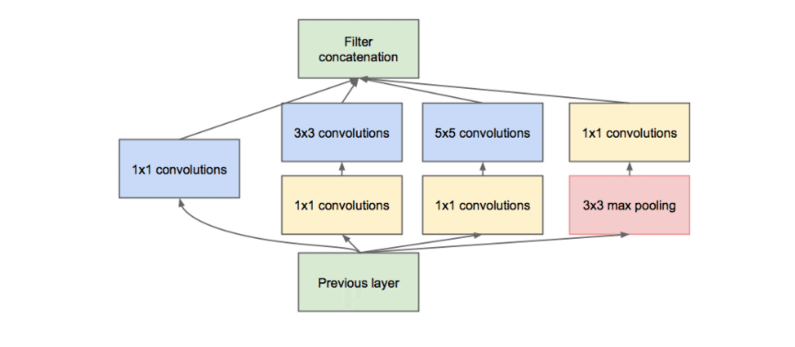



As depicted in the figure above, the inception block consists of four parallel paths. The first three paths use convolutional layers with window sizes of `1 x 1`, `3 x 3` , `5 x 5` and to extract information from different spatial sizes. The middle two paths perform `1 x 1` a convolution on the input to reduce the number of input channels, reducing the model's complexity. The fourth path uses a `3 x 3` maximum pooling layer, followed by a `1 x 1` convolutional layer to change the number of channels. The four paths all use appropriate padding to give the input and output the same height and width. Finally, the outputs along each path are concatenated along the channel dimension and comprise the block's output. The commonly-tuned parameters of the Inception block are the number of output channels per layer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Inception(nn.Module):
    # c1 - c4 are the number of output channels for each layer in the path
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels,c1,kernel_size = 1)

        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2d(in_channels,c2[0],kernel_size = 1)
        self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size = 3,padding=1)

        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2d(in_channels,c3[0],kernel_size = 1)
        self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size= 5,padding = 2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size = 3,padding=1,stride=1)
        self.p4_2 = nn.Conv2d(in_channels,c4,kernel_size = 1)

    def forward(self,x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(F.relu(self.p4_1(x))))

        return torch.cat((p1,p2,p3,p4),dim=1)

Lets implement GoogLeNet piece by piece. The first component uses a 64-channel 7×7 convolutional layer.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3,64,kernel_size = 7,stride = 2,padding = 3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1))
input= torch.randn((1,3,224,224))
out=b1(input)

In [ ]:
out.shape

torch.Size([1, 64, 56, 56])

The second component uses two convolutional layers: first, a 64-channel `1 x 1` convolutional layer, then a `3 x 3 ` convolutional layer that triples the number of channels. This corresponds to the second path in the Inception block.

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64,64,kernel_size = 1),
                   nn.ReLU(),
                   nn.Conv2d(64,192,kernel_size = 3,padding = 1),
                   nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1))
out1 = b2(out)
b2(out).shape

torch.Size([1, 192, 28, 28])

The third component connects two complete Inception blocks in series.
> The number of output channels of the first Inception block is ` 64 + 128 + 32 + 32 = 256`.

> The number of output channels of the second Inception block is `128 + 192 + 96 + 64 = 480`

In [ ]:
b3 = nn.Sequential(Inception(192,64,(96,128),(16,32),32), # output 256, 28, 28
                   Inception(256,128,(128,192),(32,96),64), # output 480, 28, 28
                   nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1)) # output 480, 14, 14
out2 = b3(out1)
out2.shape

torch.Size([1, 480, 14, 14])

In [ ]:
b4 = nn.Sequential(Inception(480,192,(96,208),(19,48),64), # output 512, 14, 14
                   Inception(512,160,(112,224),(24,64),64), # output 512,14,14
                   Inception(512,128,(128,256),(24,64),64), # output 512,14,14
                   Inception(512,112,(144,288),(32,64),64), # output 528,14,14
                   Inception(528,256,(160,320),(32,128),128), # output 832,14,14
                   nn.MaxPool2d(kernel_size = 3,stride = 2,padding=1) #output 832, 7, 7
                   )

out3 = b4(out2)
out3.shape

torch.Size([1, 832, 7, 7])

The fifth block has two Inception blocks with `56 + 320 + 128 + 128 = 384` and `384 + 384 + 128 + 128 = 1024` output channels. The number of channels assigned to each path is the same as that in the third and fourth modules, but differs in specific values. It should be noted that the fifth block is followed by the output layer. This block uses the global average pooling layer to change the height and width of each channel to 1, just as in NiN. Finally, we turn the output into a two-dimensional array followed by a fully-connected layer whose number of outputs is the number of label classes.

In [ ]:
class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.size(0),-1)
b5 = nn.Sequential(Inception(832,256,(160,320),(32,128),128),
                   Inception(832,384,(192,384),(48,128),128),
                   nn.AdaptiveMaxPool2d((1,1)),
                    Flatten()
                   )

out4 = b5(out3)
out4.shape

torch.Size([1, 1024])

In [ ]:
net = nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))


In [ ]:
X = torch.randn(size =(1,3,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, kernel_size=(1, 1),

In [ ]:
# lr = 0.1
epochs= 5
batch_size  = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = torch.optim.SGD(net.parameters(),lr = lr, momentum = 0.9,weight_decay = 0.005)

In [ ]:
import torchvision
import torchvision.transforms as transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(std = 0.5, mean = 0.5)
    ])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(std = 0.5, mean = 0.5)
    ])
train_dataset = torchvision.datasets.CIFAR10(root = './root',
                                             download = True,
                                             train = True,
                                             transform = train_transforms
                                             )
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
test_dataset = torchvision.datasets.CIFAR10(root = './root',
                                            download = True,
                                            train = False,
                                            transform = test_transforms
                                            )
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size, shuffle = False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13310984.73it/s]


Extracting ./root/cifar-10-python.tar.gz to ./root
Files already downloaded and verified


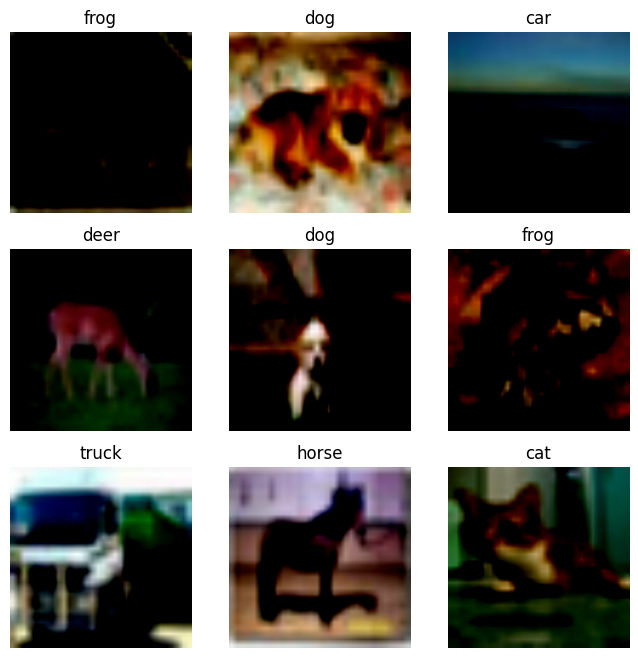

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
images , labels = next(iter(train_dataloader))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images[0].shape

fig,axes = plt.subplots(3,3,figsize = (8,8))

for i,ax in enumerate(axes.flat):
    npimage,nplabel = images[i].numpy() , labels[i].numpy()

    ax.imshow(np.transpose(npimage,(1,2,0)))
    ax.axis('off')
    ax.set_title(classes[nplabel])

In [ ]:
for epoch in range(epochs):
    for i , (images,labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        output = net(images)
        loss = criterion(output,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1} :Loss :{loss:.4f}')

Epoch 1 :Loss :1.9549
Epoch 2 :Loss :1.5721
Epoch 3 :Loss :1.3759
Epoch 4 :Loss :1.2020
Epoch 5 :Loss :1.7734


In [ ]:
with torch.no_grad():
    correct , total = 0,0
    for i,(images,labels) in enumerate(test_dataloader):
        images , labels = images.to(device) , labels.to(device)

        outputs = net(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))


Accuracy of the network on the 10000 test images: 47.91 %
